# Surprise Housing 

## A Case study for US based housing company to enter the Australian market

### We are required to build a regression model using regularisation in order to predict the actual value of the prospective properties and decide whether to invest in them or not. 
### The goal for us is to find out the optimal values of lamba for Ridge and Lasso Regression and also:
### 1. Which variables are significant in predicting the price of a house, and
### 2. How well those variables describe the price of a house.



In [30]:
#The Required library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy import stats
from scipy.stats import skew, norm

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_selection import RFE

import warnings
warnings.filterwarnings('ignore')

In [2]:
# reading the dataset. housingDf will be the dataframe holding our data
housingDf = pd.read_csv("train.csv")

In [3]:
# Basic exploration of data
print("--- DIMENSIONS ---")
print("Dataset Shape:", housingDf.shape)
print("\n--- DATA HEAD ---")
print(housingDf.head())
print("\n--- DATA INFO ---")
print("\n", housingDf.info())
print("\n---DATA STATISTICS ---")
print("\n", housingDf.describe())

--- DIMENSIONS ---
Dataset Shape: (1460, 81)

--- DATA HEAD ---
   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  Yr

In [4]:
# Target variable analysis
print("---TARGET VARIABLE : SalePrice---")
print(housingDf['SalePrice'].describe())
print(f"Skewness: {skew(housingDf['SalePrice']):.4f}")
print(f"Kurtosis: {housingDf['SalePrice'].kurtosis():.4f}")

---TARGET VARIABLE : SalePrice---
count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64
Skewness: 1.8809
Kurtosis: 6.5363


TARGET VARIABLE DISTRIBUTION


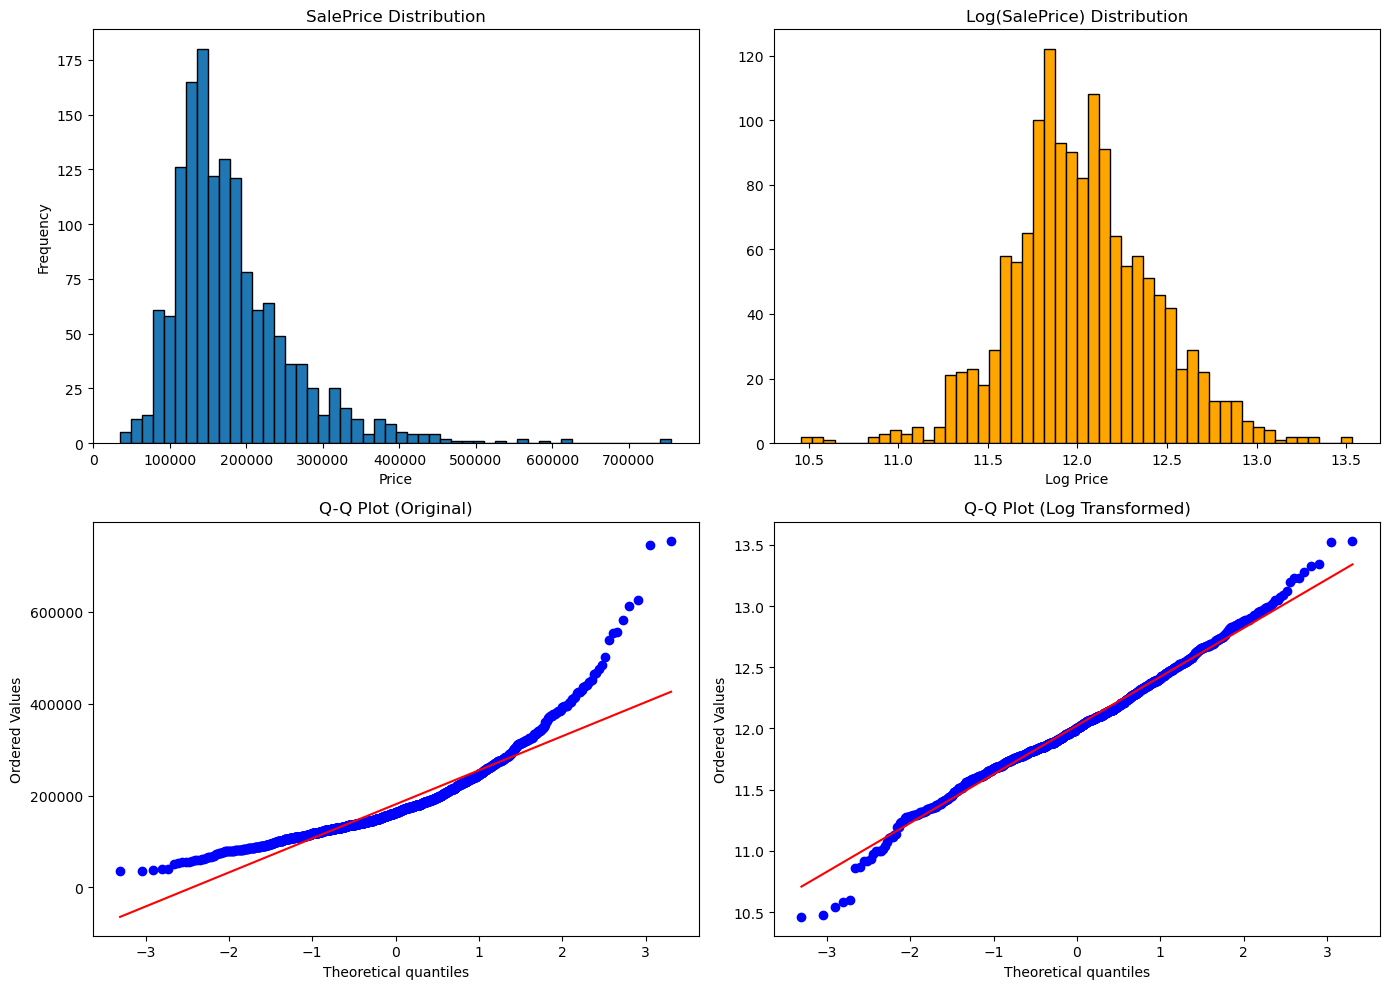


Original Skewness: 1.8809
Log Transformed Skewness: 0.1212


In [5]:
# Target variable distribution analysis

print("TARGET VARIABLE DISTRIBUTION")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Original distribution
axes[0, 0].hist(housingDf['SalePrice'], bins=50, edgecolor='black')
axes[0, 0].set_title('SalePrice Distribution')
axes[0, 0].set_xlabel('Price')
axes[0, 0].set_ylabel('Frequency')

# Log transformation
axes[0, 1].hist(np.log1p(housingDf['SalePrice']), bins=50, edgecolor='black', color='orange')
axes[0, 1].set_title('Log(SalePrice) Distribution')
axes[0, 1].set_xlabel('Log Price')

# Q-Q plot
stats.probplot(housingDf['SalePrice'], dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot (Original)')

stats.probplot(np.log1p(housingDf['SalePrice']), dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot (Log Transformed)')

plt.tight_layout()
plt.show()

print(f"\nOriginal Skewness: {skew(housingDf['SalePrice']):.4f}")
print(f"Log Transformed Skewness: {skew(np.log1p(housingDf['SalePrice'])):.4f}")

---MISSING VALUES ANALYSIS---
              Missing_Count  Percentage
PoolQC                 1453   99.520548
MiscFeature            1406   96.301370
Alley                  1369   93.767123
Fence                  1179   80.753425
MasVnrType              872   59.726027
FireplaceQu             690   47.260274
LotFrontage             259   17.739726
GarageYrBlt              81    5.547945
GarageCond               81    5.547945
GarageType               81    5.547945
GarageFinish             81    5.547945
GarageQual               81    5.547945
BsmtFinType2             38    2.602740
BsmtExposure             38    2.602740
BsmtQual                 37    2.534247
BsmtCond                 37    2.534247
BsmtFinType1             37    2.534247
MasVnrArea                8    0.547945
Electrical                1    0.068493


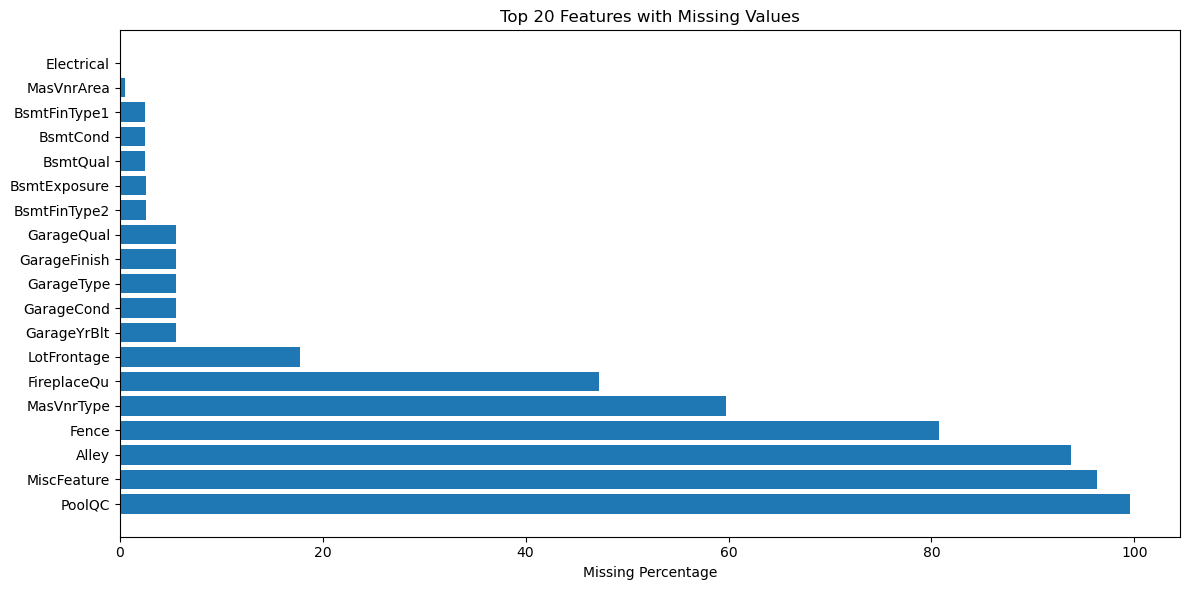

In [6]:
# Missing Values Analysis

print("---MISSING VALUES ANALYSIS---")
missing = housingDf.isnull().sum()
missing_pct = (missing / len(housingDf)) * 100
missing_df = pd.DataFrame({
    'Missing_Count': missing,
    'Percentage': missing_pct
}).sort_values('Percentage', ascending=False)

print(missing_df[missing_df['Missing_Count'] > 0])

# Visualize missing values
plt.figure(figsize=(12, 6))
missing_cols = missing_df[missing_df['Percentage'] > 0].head(20)
plt.barh(missing_cols.index, missing_cols['Percentage'])
plt.xlabel('Missing Percentage')
plt.title('Top 20 Features with Missing Values')
plt.tight_layout()
plt.show()

In [7]:
# DATA CLEANING 

duplicates = housingDf.duplicated().sum()
print(f"Duplicates found: {duplicates}")
if duplicates > 0:
    housingDf = housingDf.drop_duplicates()

Duplicates found: 0


In [8]:
# Remove irrelevant columns for analysis
housingDf = housingDf.drop('Id', axis=1)

In [9]:
# Use a copy for modifying data and cleaning
housingDf_clean = housingDf.copy()

In [10]:
# For features where NA means 'None' (no feature)
none_features = ['Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
                 'BsmtFinType2', 'FireplaceQu', 'GarageType', 'GarageFinish',
                 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']

for feature in none_features:
    if feature in housingDf_clean.columns:
        housingDf_clean[feature].fillna('None', inplace=True)


In [11]:
# For numerical features like MasVnrType and MasVnrArea
housingDf_clean['MasVnrType'].fillna('None', inplace=True)
housingDf_clean['MasVnrArea'].fillna(0, inplace=True)

In [12]:
# GarageYrBlt - fill with YearBuilt as they seem similar
housingDf_clean['GarageYrBlt'].fillna(housingDf_clean['YearBuilt'], inplace=True)

# There are few more columns with missing values but we can handle them after train-test split to ensure that the test data leakage

---CORRELATION ANALYSIS---

Top 15 Correlations with SalePrice:
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
GarageYrBlt     0.508043
YearRemodAdd    0.507101
MasVnrArea      0.472614
Fireplaces      0.466929
BsmtFinSF1      0.386420
LotFrontage     0.351799
Name: SalePrice, dtype: float64


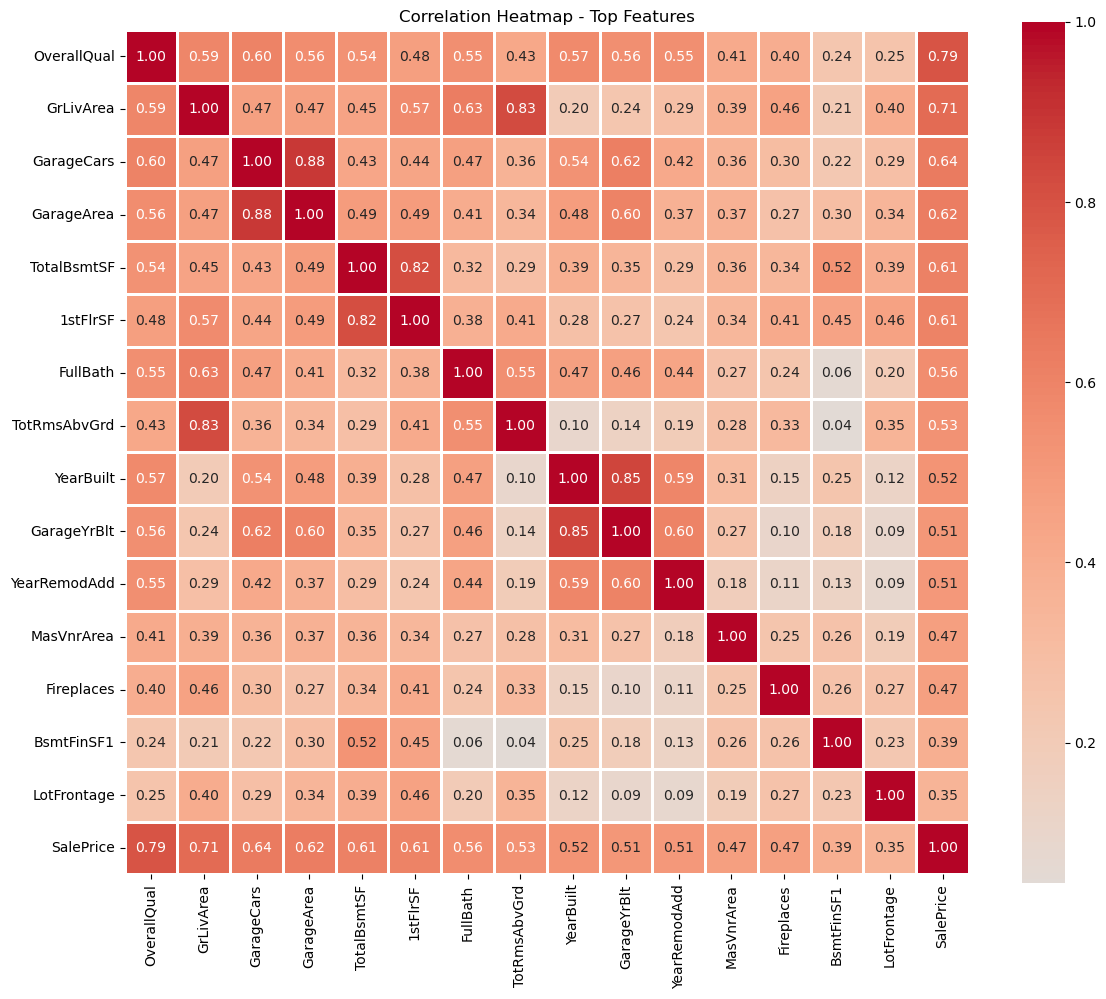

In [13]:
# Correlation Analysis

print("---CORRELATION ANALYSIS---")

# Numerical features only
numerical_features = housingDf_clean.select_dtypes(include=[np.number]).columns.tolist()

# Correlation with target
correlations = housingDf_clean[numerical_features].corr()['SalePrice'].sort_values(ascending=False)
print("\nTop 15 Correlations with SalePrice:")
print(correlations[1:16])

# Visualization
plt.figure(figsize=(12, 10))
top_features = correlations[1:16].index.tolist() + ['SalePrice']
sns.heatmap(housingDf_clean[top_features].corr(), annot=True, cmap='coolwarm', 
            center=0, fmt='.2f', square=True, linewidths=1)
plt.title('Correlation Heatmap - Top Features')
plt.tight_layout()
plt.show()


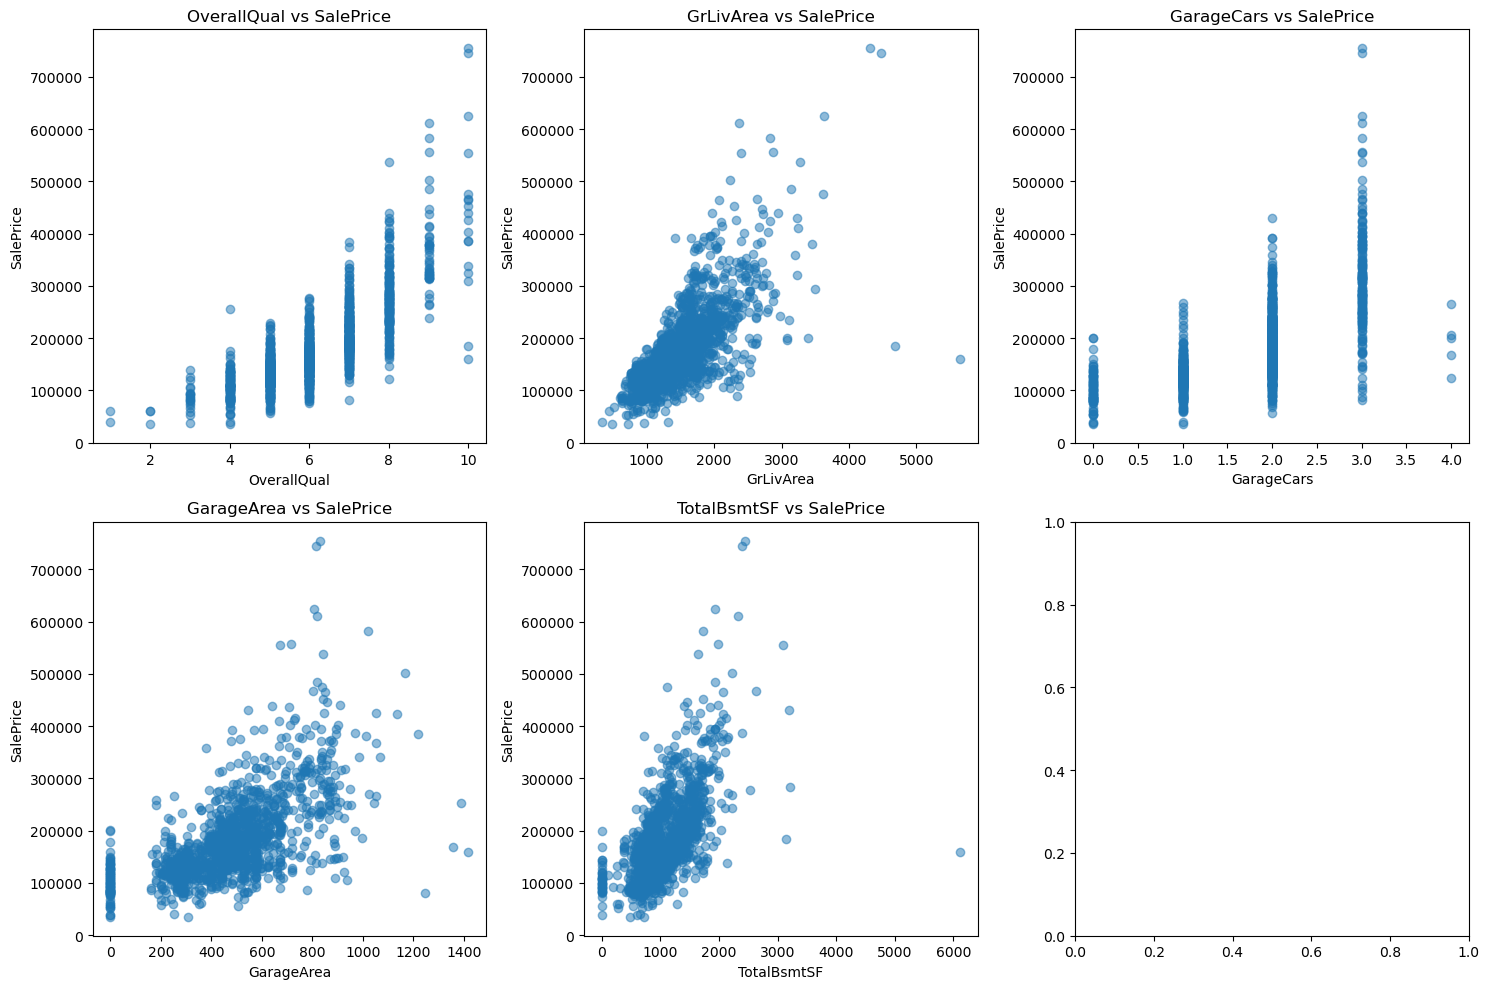

In [14]:
# Numerical Features vs Target
# This helps to identify if Linear Regression is a good fit to build this model.

# Scatter plots of top correlated features
top_5_features = correlations[1:6].index.tolist()

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for idx, feature in enumerate(top_5_features):
    axes[idx].scatter(housingDf_clean[feature], housingDf_clean['SalePrice'], alpha=0.5)
    axes[idx].set_xlabel(feature)
    axes[idx].set_ylabel('SalePrice')
    axes[idx].set_title(f'{feature} vs SalePrice')

plt.tight_layout()
plt.show()



Total Categorical Features: 43


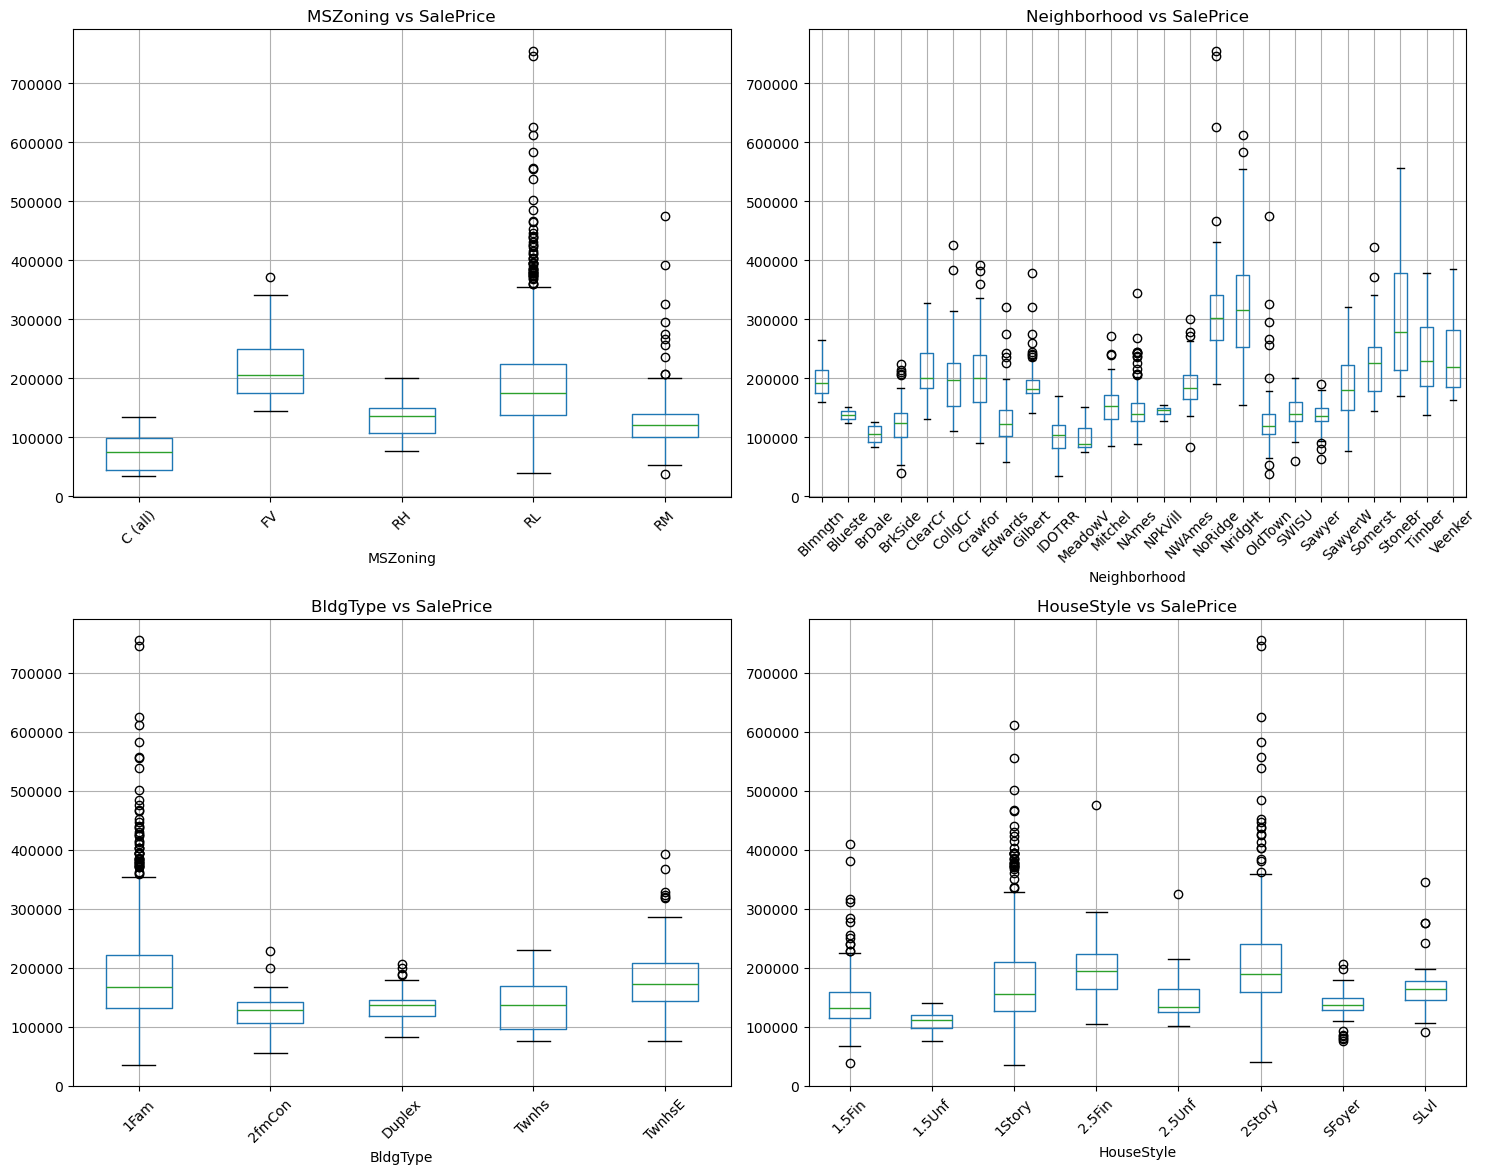

In [15]:
# Categorical Features Analysis
# If medians of each category in categorical variable are distant from each other, It shows significance of a category in analysis.

# Top categorical features
categorical_features = housingDf_clean.select_dtypes(include=['object']).columns.tolist()

print(f"\nTotal Categorical Features: {len(categorical_features)}")

# Boxplots for key categorical features
key_categorical = ['MSZoning', 'Neighborhood', 'BldgType', 'HouseStyle']

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

for idx, feature in enumerate(key_categorical):
    if feature in housingDf_clean.columns:
        housingDf_clean.boxplot(column='SalePrice', by=feature, ax=axes[idx], rot=45)
        axes[idx].set_title(f'{feature} vs SalePrice')
        axes[idx].set_xlabel(feature)
        
plt.suptitle('')
plt.tight_layout()
plt.show()


Creating pairplot for top 5 correlated features...


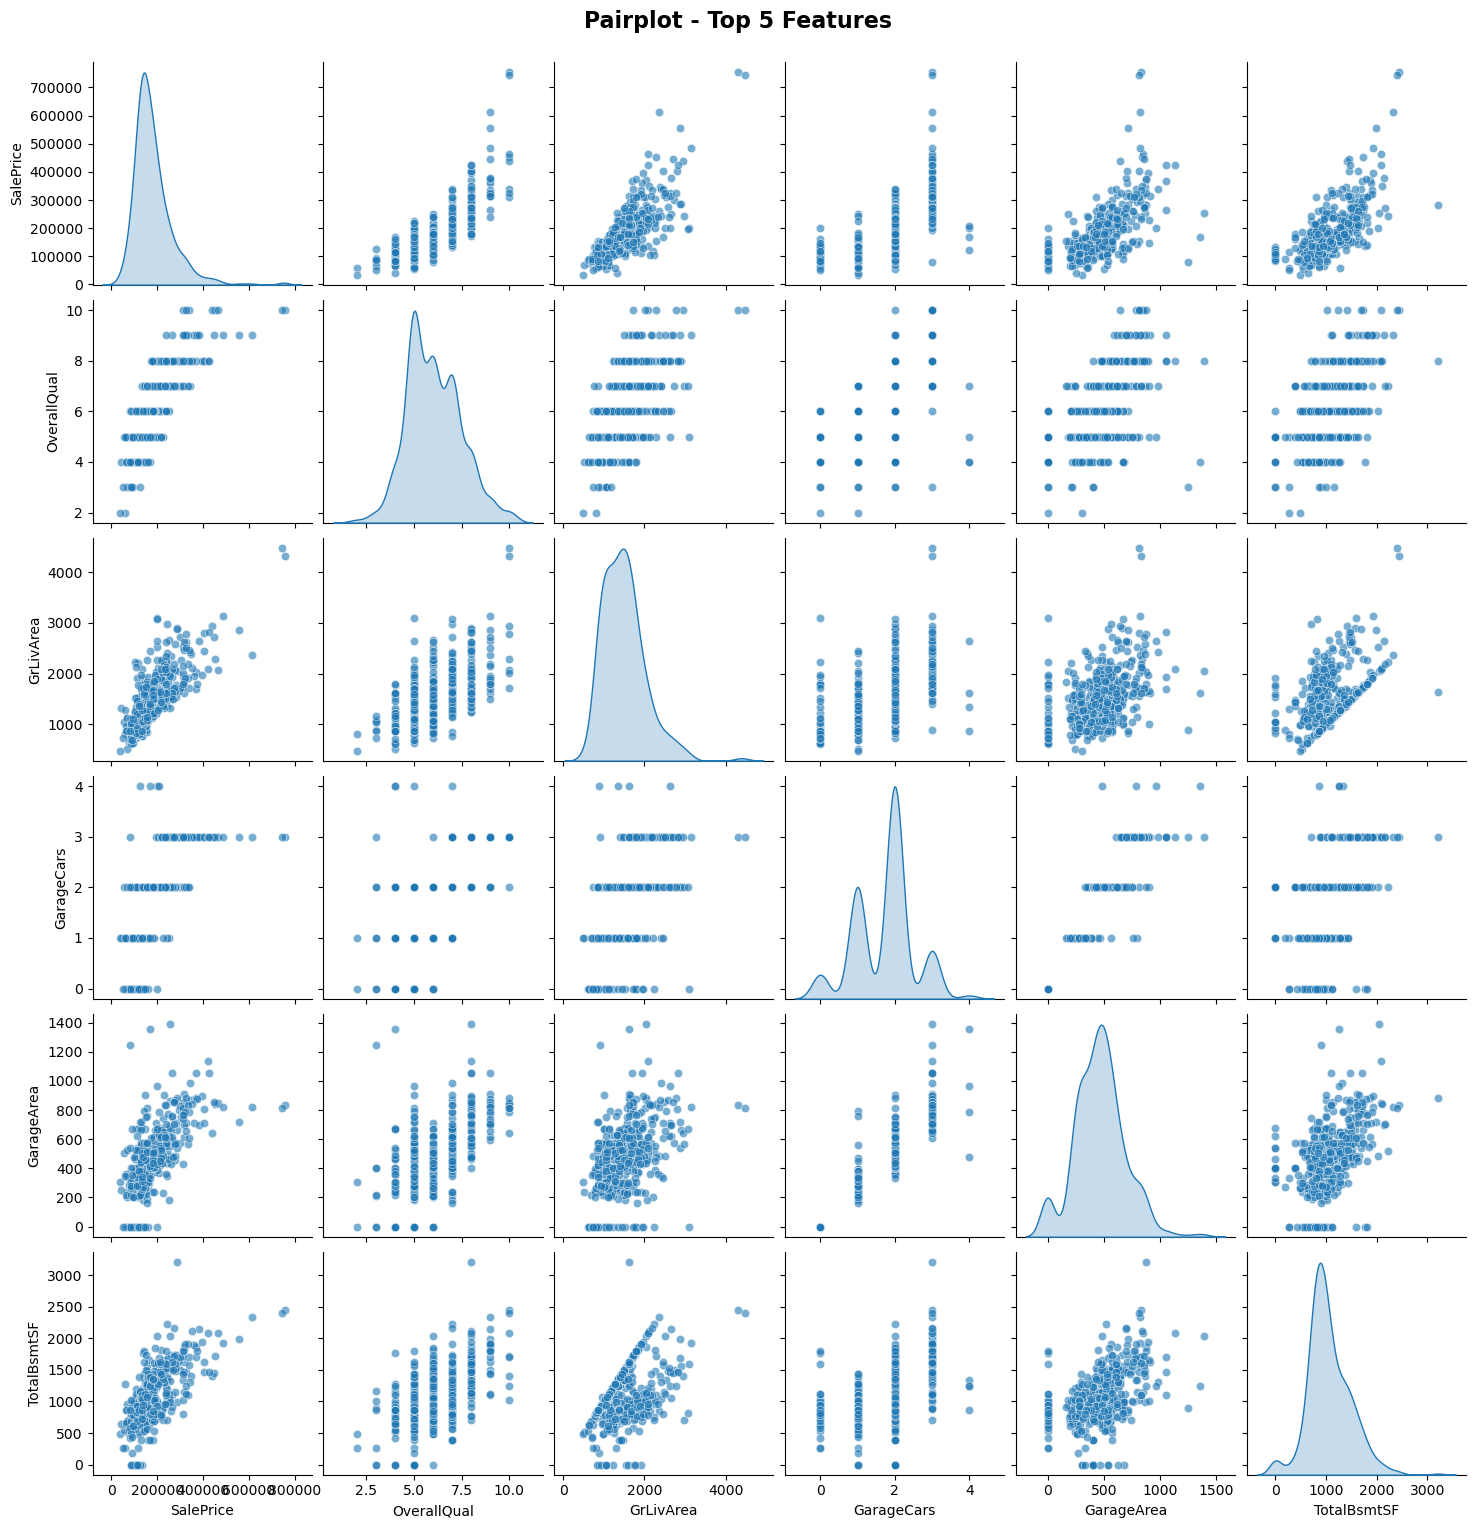


Analyzing feature interactions...


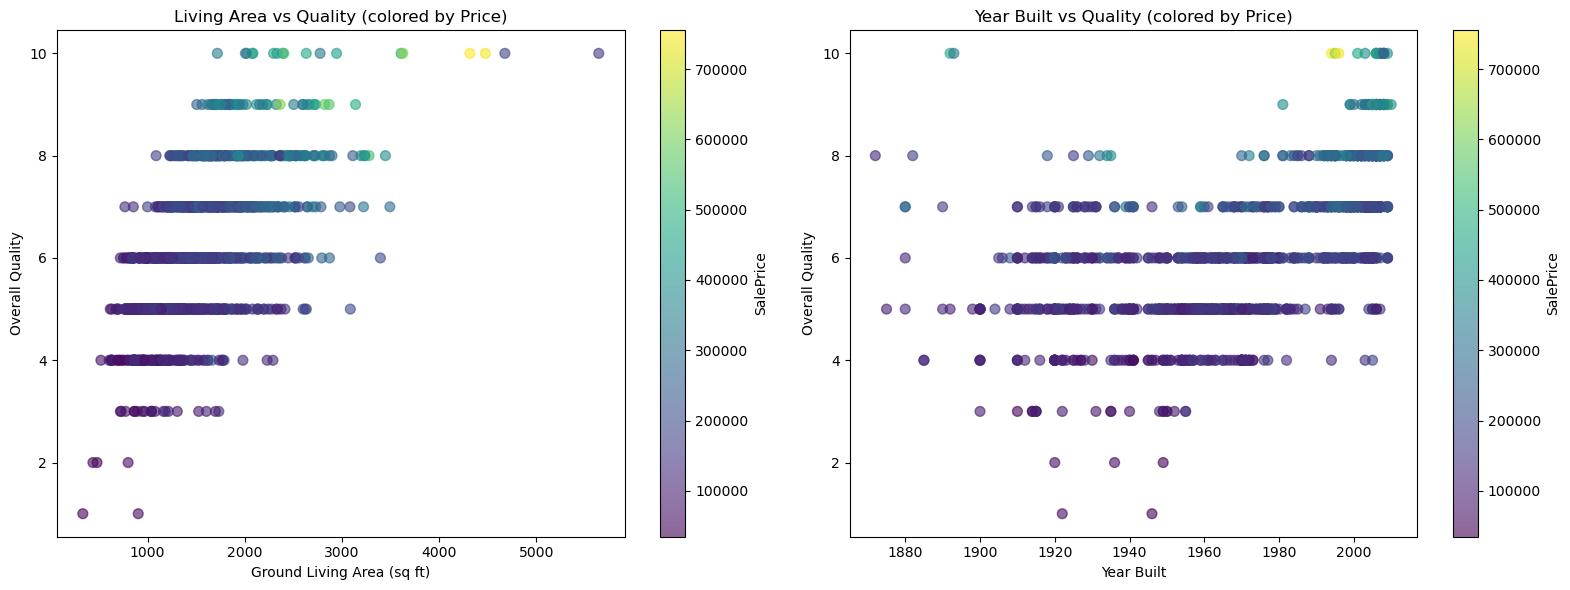

In [16]:
# Pairplot for top features
# This helps analyse correrelation more and for multi-variate analysis
top_5_features = correlations.head(6).index.tolist()
print(f"\nCreating pairplot for top 5 correlated features...")

# Sample data for faster plotting
sample_size = min(500, len(housingDf_clean))
df_sample = housingDf_clean[top_5_features].sample(n=sample_size, random_state=42)

sns.pairplot(df_sample, diag_kind='kde', plot_kws={'alpha': 0.6})
plt.suptitle('Pairplot - Top 5 Features', y=1.02, fontsize=16, fontweight='bold')
plt.show()

# Feature interactions
print("\nAnalyzing feature interactions...")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Overall Quality vs Living Area (colored by price)
scatter = axes[0].scatter(housingDf_clean['GrLivArea'], housingDf_clean['OverallQual'], 
                         c=housingDf_clean['SalePrice'], cmap='viridis', 
                         alpha=0.6, s=50)
axes[0].set_xlabel('Ground Living Area (sq ft)')
axes[0].set_ylabel('Overall Quality')
axes[0].set_title('Living Area vs Quality (colored by Price)')
plt.colorbar(scatter, ax=axes[0], label='SalePrice')

# Year Built vs Quality (colored by price)
scatter = axes[1].scatter(housingDf_clean['YearBuilt'], housingDf_clean['OverallQual'], 
                         c=housingDf_clean['SalePrice'], cmap='viridis', 
                         alpha=0.6, s=50)
axes[1].set_xlabel('Year Built')
axes[1].set_ylabel('Overall Quality')
axes[1].set_title('Year Built vs Quality (colored by Price)')
plt.colorbar(scatter, ax=axes[1], label='SalePrice')

plt.tight_layout()
plt.show()

In [17]:
print("--- TRAIN-TEST SPLIT (70:30) ---")

# Separate features and target
X = housingDf_clean.drop('SalePrice', axis=1)
y = housingDf_clean['SalePrice']

print(f"\nOriginal dataset:")
print(f"  Features (X): {X.shape}")
print(f"  Target (y): {y.shape}")

# Split data (70:30)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42
)

print(f"\n✓ Data split completed")
print(f"  Training set: {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"  Test set: {X_test.shape[0]} samples ({X_test.shape[0]/len(X)*100:.1f}%)")

print(f"\nTraining set statistics:")
print(f"  SalePrice mean: ${y_train.mean():,.2f}")
print(f"  SalePrice std: ${y_train.std():,.2f}")

print(f"\nTest set statistics:")
print(f"  SalePrice mean: ${y_test.mean():,.2f}")
print(f"  SalePrice std: ${y_test.std():,.2f}")


--- TRAIN-TEST SPLIT (70:30) ---

Original dataset:
  Features (X): (1460, 79)
  Target (y): (1460,)

✓ Data split completed
  Training set: 1022 samples (70.0%)
  Test set: 438 samples (30.0%)

Training set statistics:
  SalePrice mean: $181,312.69
  SalePrice std: $77,617.46

Test set statistics:
  SalePrice mean: $180,007.70
  SalePrice std: $83,630.51


In [18]:
# Handling the pending missing items now after train test split to prevent data leakage
#Filling Electrical column with the mode value

if 'Electrical' in X_train.columns:
    # Check missing values
    train_missing = X_train['Electrical'].isnull().sum()
    test_missing = X_test['Electrical'].isnull().sum()
    
    if train_missing > 0 or test_missing > 0:
        # STEP 1: Learn mode from TRAINING set only
        mode_electrical = X_train['Electrical'].mode()[0]
        
        print(f"  Missing in training set: {train_missing}")
        print(f"  Missing in test set: {test_missing}")
        print(f"  Mode from training set: '{mode_electrical}'")
        
        # STEP 2: Apply to BOTH train and test
        X_train['Electrical'].fillna(mode_electrical, inplace=True)
        X_test['Electrical'].fillna(mode_electrical, inplace=True)
        
        print(f"   Imputed both sets with training mode: '{mode_electrical}'")
    else:
        print(f"  No missing values in Electrical")

  Missing in training set: 1
  Missing in test set: 0
  Mode from training set: 'SBrkr'
   Imputed both sets with training mode: 'SBrkr'


In [19]:
# Filling the LotFrontage column with a neighbourhood specific median
print("--LotFrontage - Neighborhood-Specific Median---")

if 'LotFrontage' in X_train.columns and 'Neighborhood' in X_train.columns:
    
    # Check missing values
    train_missing_before = X_train['LotFrontage'].isnull().sum()
    test_missing_before = X_test['LotFrontage'].isnull().sum()
    
    print(f"  Missing before imputation:")
    print(f"    Training set: {train_missing_before}")
    print(f"    Test set: {test_missing_before}")
    
    if train_missing_before > 0 or test_missing_before > 0:
        
        # Learn neighborhood-specific medians from TRAINING set only
        neighborhood_medians = X_train.groupby('Neighborhood')['LotFrontage'].median()
        
        # Calculate overall median as fallback for neighborhoods not in training
        overall_median = X_train['LotFrontage'].median()
        
        print(f"\n  Learned statistics from TRAINING set:")
        print(f"    Neighborhoods with data: {len(neighborhood_medians)}")
        print(f"    Overall median (fallback): {overall_median:.2f}")
        print(f"\n  Sample neighborhood medians:")
        print(neighborhood_medians.head(10).to_string())
        
        # STEP 2: Create imputation function
        def impute_lotfrontage(row, medians_dict, fallback_median):
            if pd.isna(row['LotFrontage']):
                neighborhood = row['Neighborhood']
                # Use neighborhood median if available, otherwise use overall median
                if neighborhood in medians_dict.index:
                    return medians_dict[neighborhood]
                else:
                    return fallback_median
            return row['LotFrontage']
        
        # STEP 3: Apply to TRAINING set
        X_train['LotFrontage'] = X_train.apply(
            lambda row: impute_lotfrontage(row, neighborhood_medians, overall_median),
            axis=1
        )
        
        # STEP 4: Apply to TEST set (using TRAINING statistics!)
        X_test['LotFrontage'] = X_test.apply(
            lambda row: impute_lotfrontage(row, neighborhood_medians, overall_median),
            axis=1
        )
        
        # Verify
        train_missing_after = X_train['LotFrontage'].isnull().sum()
        test_missing_after = X_test['LotFrontage'].isnull().sum()
        
        print(f"\n  Missing after imputation:")
        print(f"    Training set: {train_missing_before} → {train_missing_after}")
        print(f"    Test set: {test_missing_before} → {test_missing_after}")
        print(f"\n  Imputed using neighborhood-specific medians from TRAINING set")
        
        # Show which neighborhoods were imputed in test
        if test_missing_before > 0:
            test_neighborhoods = X_test[X_test.index.isin(
                X_test[X_test['LotFrontage'].isnull()].index
            )]['Neighborhood'].unique()
            

--LotFrontage - Neighborhood-Specific Median---
  Missing before imputation:
    Training set: 190
    Test set: 69

  Learned statistics from TRAINING set:
    Neighborhoods with data: 25
    Overall median (fallback): 70.00

  Sample neighborhood medians:
Neighborhood
Blmngtn    43.0
Blueste    24.0
BrDale     21.0
BrkSide    52.0
ClearCr    80.0
CollgCr    70.0
Crawfor    70.0
Edwards    65.5
Gilbert    65.0
IDOTRR     60.0

  Missing after imputation:
    Training set: 190 → 0
    Test set: 69 → 0

  Imputed using neighborhood-specific medians from TRAINING set


In [20]:
# Verifying if all the missing values are handled

print("\nTraining set missing values:")
print(X_train.isnull().sum().sum())
print("\nTest set missing values:")
print(X_test.isnull().sum().sum())


Training set missing values:
0

Test set missing values:
0


---OUTLIER DETECTION AND TREATMENT---

Analyzing outliers in 36 numerical features...

Outlier Summary:
  Total outlier instances: 1167
  Unique rows with outliers: 627
  Percentage of data: 61.35%

Top 15 features with most outliers:
      Feature  Outlier_Count
EnclosedPorch            138
   BsmtFinSF2            111
  ScreenPorch             86
  OverallCond             85
   MSSubClass             75
   GarageArea             73
  LotFrontage             67
   MasVnrArea             62
 BsmtHalfBath             60
  OpenPorchSF             54
 KitchenAbvGr             48
      LotArea             46
  TotalBsmtSF             43
      MiscVal             40
   WoodDeckSF             26


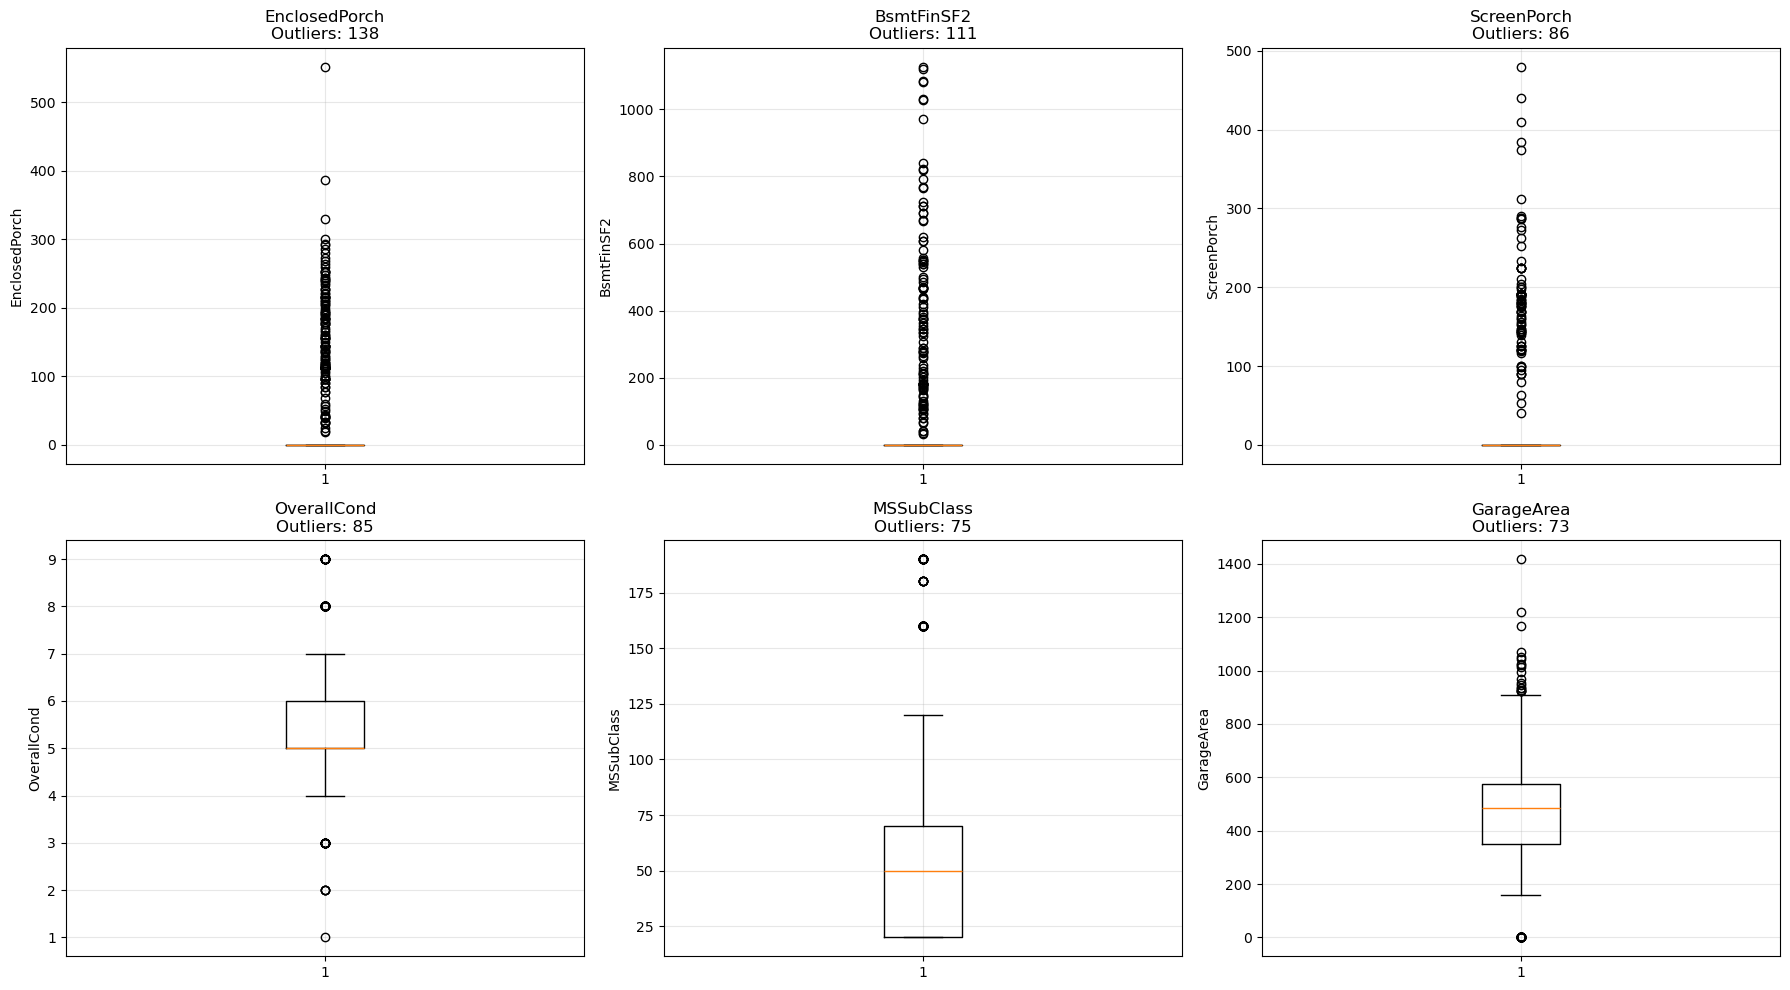


Target Variable (SalePrice) Outlier Analysis:
  Outliers detected: 41
  Percentage: 4.01%


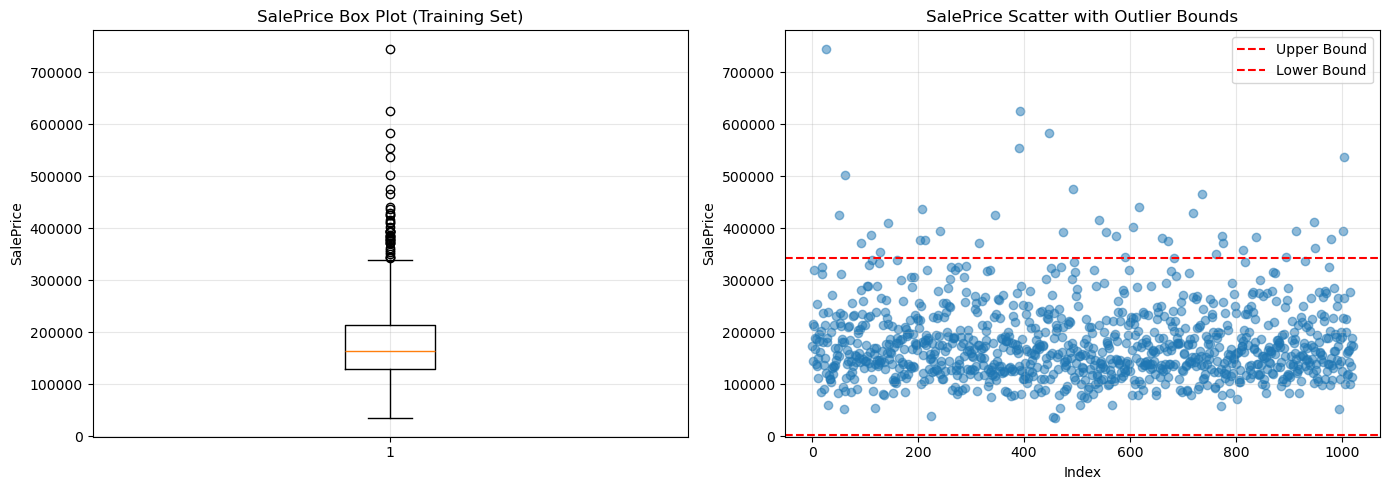

In [21]:
# OUTLIER DETECTION AND TREATMENT

print("---OUTLIER DETECTION AND TREATMENT---")

# Identify numerical features
num_features = X_train.select_dtypes(include=[np.number]).columns.tolist()

print(f"\nAnalyzing outliers in {len(num_features)} numerical features...")

# Detect outliers using IQR method
def detect_outliers_iqr(df, features):
    """Detect outliers using IQR method"""
    outlier_indices = []
    outlier_counts = {}
    
    for feature in features:
        Q1 = df[feature].quantile(0.25)
        Q3 = df[feature].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outlier_list = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)].index
        outlier_indices.extend(outlier_list)
        outlier_counts[feature] = len(outlier_list)
    
    return outlier_indices, outlier_counts

outlier_indices, outlier_counts = detect_outliers_iqr(X_train, num_features)

# Count unique outlier rows
unique_outliers = len(set(outlier_indices))
print(f"\nOutlier Summary:")
print(f"  Total outlier instances: {len(outlier_indices)}")
print(f"  Unique rows with outliers: {unique_outliers}")
print(f"  Percentage of data: {unique_outliers/len(X_train)*100:.2f}%")

# Features with most outliers
outlier_df = pd.DataFrame(list(outlier_counts.items()), 
                          columns=['Feature', 'Outlier_Count'])
outlier_df = outlier_df.sort_values('Outlier_Count', ascending=False).head(15)

print(f"\nTop 15 features with most outliers:")
print(outlier_df.to_string(index=False))

# Visualize outliers for key features
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

top_outlier_features = outlier_df.head(6)['Feature'].tolist()

for idx, feature in enumerate(top_outlier_features):
    axes[idx].boxplot(X_train[feature], vert=True)
    axes[idx].set_ylabel(feature)
    axes[idx].set_title(f'{feature}\nOutliers: {outlier_counts[feature]}')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Check target variable outliers
print("\nTarget Variable (SalePrice) Outlier Analysis:")
Q1_y = y_train.quantile(0.25)
Q3_y = y_train.quantile(0.75)
IQR_y = Q3_y - Q1_y
lower_y = Q1_y - 1.5 * IQR_y
upper_y = Q3_y + 1.5 * IQR_y

outliers_y = y_train[(y_train < lower_y) | (y_train > upper_y)]
print(f"  Outliers detected: {len(outliers_y)}")
print(f"  Percentage: {len(outliers_y)/len(y_train)*100:.2f}%")

# Visualize target outliers
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].boxplot(y_train)
axes[0].set_ylabel('SalePrice')
axes[0].set_title('SalePrice Box Plot (Training Set)')
axes[0].grid(True, alpha=0.3)

axes[1].scatter(range(len(y_train)), y_train, alpha=0.5)
axes[1].axhline(y=upper_y, color='r', linestyle='--', label='Upper Bound')
axes[1].axhline(y=lower_y, color='r', linestyle='--', label='Lower Bound')
axes[1].set_xlabel('Index')
axes[1].set_ylabel('SalePrice')
axes[1].set_title('SalePrice Scatter with Outlier Bounds')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [22]:
# We have 61% outliers in 36 numerical features
# Removing them may result in losing important data. We will follow a conservative approach as follows: 
# 1. Log transform target
# 2. Log transform features with |skew| > 1
# 3. Winsorize features with 0.5 < |skew| <= 1

# 1. Log transform target
y_train = np.log1p(y_train)
y_test = np.log1p(y_test)

# 2. Log transform features with |skew| > 1
skewed_features = X_train.select_dtypes(include=[np.number]).apply(
    lambda x: x.skew()
).sort_values(ascending=False)

for feature in skewed_features[abs(skewed_features) > 1].index:
    X_train[feature] = np.log1p(X_train[feature])
    X_test[feature] = np.log1p(X_test[feature])

  

In [24]:
# 3. Winsorize features with 0.5 < |skew| <= 1

moderately_skewed = skewed_features[(abs(skewed_features) > 0.5) & (abs(skewed_features) <= 1)].index.tolist()

# Method definition for winsorization
def apply_winsorization(train_df, test_df, features, lower_pct=0.01, upper_pct=0.99):
    train_df = train_df.copy()
    test_df = test_df.copy()
    
    stats = []
    
    for feature in features:
        if feature in train_df.columns:
            # Learn from training
            lower = train_df[feature].quantile(lower_pct)
            upper = train_df[feature].quantile(upper_pct)
            
            # Apply to both
            train_df[feature] = train_df[feature].clip(lower, upper)
            test_df[feature] = test_df[feature].clip(lower, upper)
            
            stats.append({
                'feature': feature,
                'lower_bound': lower,
                'upper_bound': upper
            })
    
    return train_df, test_df, pd.DataFrame(stats)

# Invoke the function declared above for winsorization
X_train, X_test, winsor_stats = apply_winsorization(
    X_train, X_test, moderately_skewed
)

In [25]:
# Encode categorical variables

print("\nEncoding categorical variables...")
categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()

print(f"  Categorical features: {len(categorical_cols)}")
print(f"  Numerical features: {len(numerical_cols)}")

# One-hot encoding
X_train_encoded = pd.get_dummies(X_train, drop_first=True)
X_test_encoded = pd.get_dummies(X_test, drop_first=True)

# Align train and test sets (ensure same columns)
X_train_encoded, X_test_encoded = X_train_encoded.align(X_test_encoded, 
                                                         join='left', 
                                                         axis=1, 
                                                         fill_value=0)

print(f"\n Encoding completed")
print(f"  Features after encoding: {X_train_encoded.shape[1]}")



Encoding categorical variables...
  Categorical features: 43
  Numerical features: 36

 Encoding completed
  Features after encoding: 254


In [26]:
# Scaling using Standard Scaler

scaler = StandardScaler()

X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train_encoded),
    columns=X_train_encoded.columns,
    index=X_train_encoded.index
)

X_test_scaled = pd.DataFrame(
    scaler.transform(X_test_encoded),
    columns=X_test_encoded.columns,
    index=X_test_encoded.index
)


Testing different feature counts...
--------------------------------------------------------------------------------
Features     CV Score (mean)      CV Score (std)      
--------------------------------------------------------------------------------
30           0.8478               0.0736              
50           0.8531               0.0807              
75           0.8741               0.0616              
100          0.8774               0.0624              
150          0.8764               0.0704              
200          0.8615               0.0750              

✓ Optimal number of features: 100

Performing final RFE with 100 features...

 RFE completed
  Selected features: 100
  Eliminated features: 154

Selected features dataset shape:
  Training: (1022, 100)
  Test: (438, 100)

Top 20 Selected Features:
--------------------------------------------------------------------------------
            Feature  Selected  Ranking
Exterior1st_Wd Sdng      True        1
  BsmtE

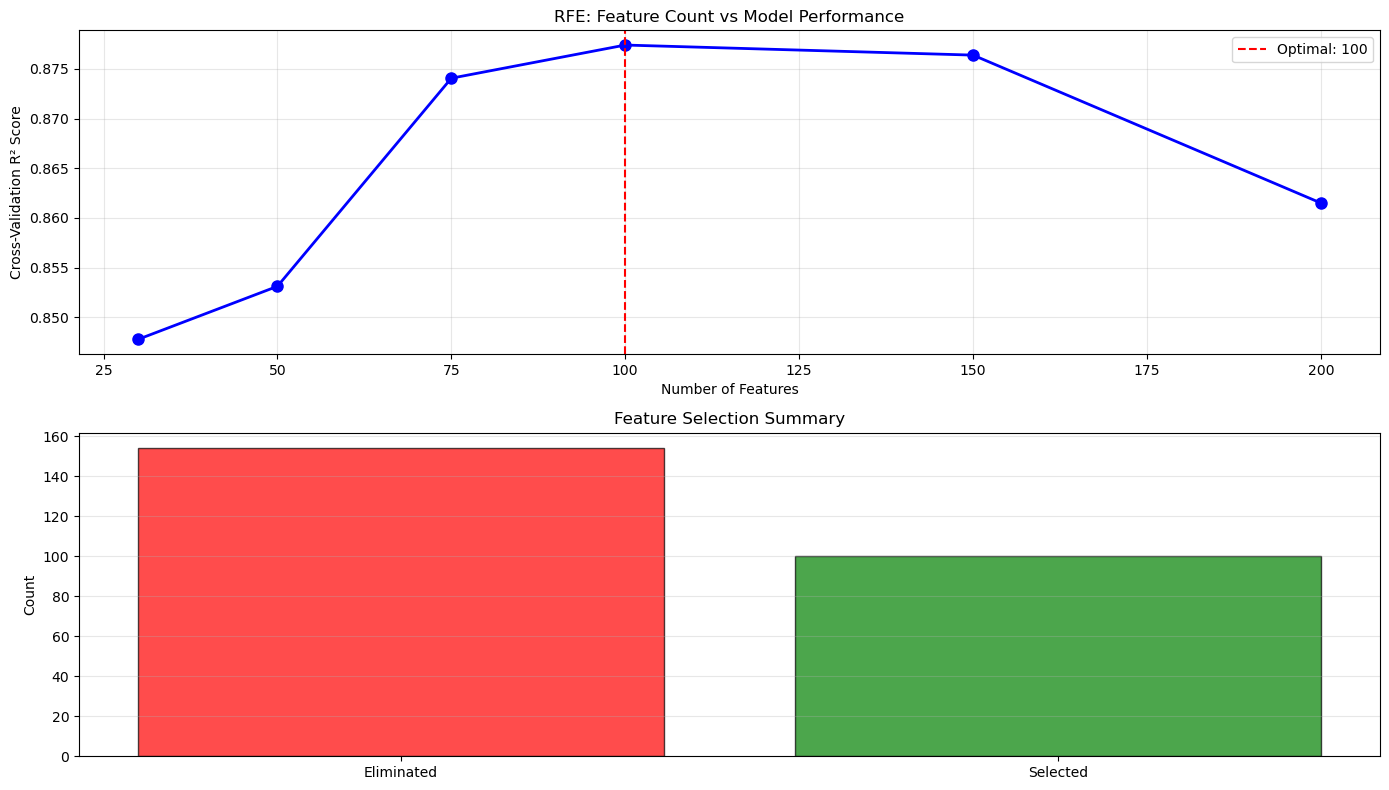

In [27]:
# Performing RFE to eliminate insignificant features

feature_counts = [30, 50, 75, 100, 150, 200]
cv_scores = []

print("\nTesting different feature counts...")
print("-" * 80)
print(f"{'Features':<12} {'CV Score (mean)':<20} {'CV Score (std)':<20}")
print("-" * 80)

for n_features in feature_counts:
    if n_features <= X_train_scaled.shape[1]:
        # Create RFE object
        lm = LinearRegression()
        rfe = RFE(lm, n_features_to_select=n_features)
        
        # Fit RFE
        rfe.fit(X_train_scaled, y_train)
        
        # Get selected features
        X_train_rfe = X_train_scaled.loc[:, rfe.support_]
        
        # Cross-validation score
        scores = cross_val_score(lm, X_train_rfe, y_train, 
                                cv=5, scoring='r2')
        cv_scores.append((n_features, scores.mean(), scores.std()))
        
        print(f"{n_features:<12} {scores.mean():<20.4f} {scores.std():<20.4f}")

# Select optimal number of features
optimal_features = max(cv_scores, key=lambda x: x[1])[0]
print(f"\n✓ Optimal number of features: {optimal_features}")

# Perform final RFE with optimal number
print(f"\nPerforming final RFE with {optimal_features} features...")

lm = LinearRegression()
rfe = RFE(lm, n_features_to_select=optimal_features)
rfe.fit(X_train_scaled, y_train)

# Get selected features
selected_features = X_train_scaled.columns[rfe.support_].tolist()
eliminated_features = X_train_scaled.columns[~rfe.support_].tolist()

print(f"\n RFE completed")
print(f"  Selected features: {len(selected_features)}")
print(f"  Eliminated features: {len(eliminated_features)}")

# Create datasets with selected features
X_train_rfe = X_train_scaled[selected_features]
X_test_rfe = X_test_scaled[selected_features]

print(f"\nSelected features dataset shape:")
print(f"  Training: {X_train_rfe.shape}")
print(f"  Test: {X_test_rfe.shape}")

# Display feature rankings
feature_ranking = pd.DataFrame({
    'Feature': X_train_scaled.columns,
    'Selected': rfe.support_,
    'Ranking': rfe.ranking_
}).sort_values('Ranking')

print(f"\nTop 20 Selected Features:")
print("-" * 80)
print(feature_ranking[feature_ranking['Selected'] == True].head(20).to_string(index=False))

# Visualize feature selection
plt.figure(figsize=(14, 8))
plt.subplot(2, 1, 1)
plt.plot([x[0] for x in cv_scores], [x[1] for x in cv_scores], 'bo-', linewidth=2, markersize=8)
plt.axvline(optimal_features, color='r', linestyle='--', label=f'Optimal: {optimal_features}')
plt.xlabel('Number of Features')
plt.ylabel('Cross-Validation R² Score')
plt.title('RFE: Feature Count vs Model Performance')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 1, 2)
selection_counts = feature_ranking['Selected'].value_counts()
plt.bar(['Eliminated', 'Selected'], [selection_counts[False], selection_counts[True]], 
        color=['red', 'green'], alpha=0.7, edgecolor='black')
plt.ylabel('Count')
plt.title('Feature Selection Summary')
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


In [28]:
# Baseline model Linear Regression
print("---BASELINE MODEL - LINEAR REGRESSION---")

# Train baseline model
lr_model = LinearRegression()
lr_model.fit(X_train_rfe, y_train)

# Predictions
y_train_pred_lr = lr_model.predict(X_train_rfe)
y_test_pred_lr = lr_model.predict(X_test_rfe)

# Metrics (log scale)
train_r2_lr = r2_score(y_train, y_train_pred_lr)
test_r2_lr = r2_score(y_test, y_test_pred_lr)
train_rmse_lr = np.sqrt(mean_squared_error(y_train, y_train_pred_lr))
test_rmse_lr = np.sqrt(mean_squared_error(y_test, y_test_pred_lr))

# Convert to original scale
y_train_pred_lr_orig = np.expm1(y_train_pred_lr)
y_test_pred_lr_orig = np.expm1(y_test_pred_lr)
y_train_orig = np.expm1(y_train)
y_test_orig = np.expm1(y_test)

test_rmse_lr_orig = np.sqrt(mean_squared_error(y_test_orig, y_test_pred_lr_orig))

print(f"\nBaseline Linear Regression Performance:")
print(f"  Training R²:       {train_r2_lr:.4f}")
print(f"  Test R²:           {test_r2_lr:.4f}")
print(f"  Training RMSE (log): {train_rmse_lr:.4f}")
print(f"  Test RMSE (log):   {test_rmse_lr:.4f}")
print(f"  Test RMSE ($):     ${test_rmse_lr_orig:,.2f}")


---BASELINE MODEL - LINEAR REGRESSION---

Baseline Linear Regression Performance:
  Training R²:       0.9437
  Test R²:           0.8338
  Training RMSE (log): 0.0935
  Test RMSE (log):   0.1679
  Test RMSE ($):     $30,825.39


## Regularisation

In [31]:
# Ridge Regresion

print("---RIDGE REGRESSION---")

# Use RidgeCV to find optimal alpha
print("\nFinding optimal alpha for Ridge using Cross-Validation...")

alphas_ridge = np.logspace(0, 4, 200)
ridge_cv = RidgeCV(alphas=alphas_ridge, cv=10, scoring='r2')
ridge_cv.fit(X_train_rfe, y_train)

optimal_alpha_ridge = ridge_cv.alpha_

print(f" Optimal Alpha (Ridge): {optimal_alpha_ridge:.6f}")

# Train Ridge model with optimal alpha
ridge_model = Ridge(alpha=optimal_alpha_ridge)
ridge_model.fit(X_train_rfe, y_train)

# Predictions
y_train_pred_ridge = ridge_model.predict(X_train_rfe)
y_test_pred_ridge = ridge_model.predict(X_test_rfe)

# Metrics (log scale)
train_r2_ridge = r2_score(y_train, y_train_pred_ridge)
test_r2_ridge = r2_score(y_test, y_test_pred_ridge)
train_rmse_ridge = np.sqrt(mean_squared_error(y_train, y_train_pred_ridge))
test_rmse_ridge = np.sqrt(mean_squared_error(y_test, y_test_pred_ridge))

# Convert to original scale
y_train_pred_ridge_orig = np.expm1(y_train_pred_ridge)
y_test_pred_ridge_orig = np.expm1(y_test_pred_ridge)

test_rmse_ridge_orig = np.sqrt(mean_squared_error(y_test_orig, y_test_pred_ridge_orig))
test_mae_ridge_orig = mean_absolute_error(y_test_orig, y_test_pred_ridge_orig)

# Cross-validation
cv_scores_ridge = cross_val_score(ridge_model, X_train_rfe, y_train, 
                                  cv=10, scoring='r2')

print(f"\nRidge Regression Performance:")
print(f"  Training R²:         {train_r2_ridge:.4f}")
print(f"  Test R²:             {test_r2_ridge:.4f}")
print(f"  CV R² (mean±std):    {cv_scores_ridge.mean():.4f} ± {cv_scores_ridge.std():.4f}")
print(f"  Training RMSE (log): {train_rmse_ridge:.4f}")
print(f"  Test RMSE (log):     {test_rmse_ridge:.4f}")
print(f"  Test RMSE ($):       ${test_rmse_ridge_orig:,.2f}")
print(f"  Test MAE ($):        ${test_mae_ridge_orig:,.2f}")

# Feature coefficients
ridge_coef = pd.DataFrame({
    'Feature': X_train_rfe.columns,
    'Coefficient': ridge_model.coef_
}).sort_values('Coefficient', key=abs, ascending=False)

print(f"\nTop 15 Features by Coefficient (Ridge):")
print(ridge_coef.head(15).to_string(index=False))


---RIDGE REGRESSION---

Finding optimal alpha for Ridge using Cross-Validation...
 Optimal Alpha (Ridge): 155.222536

Ridge Regression Performance:
  Training R²:         0.9229
  Test R²:             0.8729
  CV R² (mean±std):    0.8723 ± 0.0642
  Training RMSE (log): 0.1093
  Test RMSE (log):     0.1468
  Test RMSE ($):       $27,944.94
  Test MAE ($):        $16,755.85

Top 15 Features by Coefficient (Ridge):
        Feature  Coefficient
      GrLivArea     0.095530
    OverallQual     0.067059
        LotArea     0.050103
     GarageCars     0.031914
     BsmtFinSF1     0.031620
      PoolQC_Gd    -0.031391
    TotalBsmtSF     0.030840
    OverallCond     0.029765
      YearBuilt     0.029145
    BsmtQual_TA    -0.029043
   YearRemodAdd     0.025655
 KitchenQual_TA    -0.023597
Condition2_PosN    -0.022548
BsmtExposure_Gd     0.021043
Condition1_Norm     0.020896


In [32]:
# Lasso Regression

print("---LASSO REGRESSION---")

# Use LassoCV to find optimal alpha
print("\nFinding optimal alpha for Lasso using Cross-Validation...")

alphas_lasso = np.logspace(-2, -2, 200)
lasso_cv = LassoCV(alphas=alphas_lasso, cv=10, random_state=42, max_iter=10000)
lasso_cv.fit(X_train_rfe, y_train)

optimal_alpha_lasso = lasso_cv.alpha_

print(f" Optimal Alpha (Lasso): {optimal_alpha_lasso:.6f}")

# Train Lasso model with optimal alpha
lasso_model = Lasso(alpha=optimal_alpha_lasso, max_iter=10000, random_state=42)
lasso_model.fit(X_train_rfe, y_train)

# Predictions
y_train_pred_lasso = lasso_model.predict(X_train_rfe)
y_test_pred_lasso = lasso_model.predict(X_test_rfe)

# Metrics (log scale)
train_r2_lasso = r2_score(y_train, y_train_pred_lasso)
test_r2_lasso = r2_score(y_test, y_test_pred_lasso)
train_rmse_lasso = np.sqrt(mean_squared_error(y_train, y_train_pred_lasso))
test_rmse_lasso = np.sqrt(mean_squared_error(y_test, y_test_pred_lasso))

# Convert to original scale
y_train_pred_lasso_orig = np.expm1(y_train_pred_lasso)
y_test_pred_lasso_orig = np.expm1(y_test_pred_lasso)

test_rmse_lasso_orig = np.sqrt(mean_squared_error(y_test_orig, y_test_pred_lasso_orig))
test_mae_lasso_orig = mean_absolute_error(y_test_orig, y_test_pred_lasso_orig)

# Cross-validation
cv_scores_lasso = cross_val_score(lasso_model, X_train_rfe, y_train, 
                                  cv=10, scoring='r2')

# Feature selection
lasso_coef = pd.DataFrame({
    'Feature': X_train_rfe.columns,
    'Coefficient': lasso_model.coef_
}).sort_values('Coefficient', key=abs, ascending=False)

non_zero_coef = (lasso_coef['Coefficient'] != 0).sum()
zero_coef = (lasso_coef['Coefficient'] == 0).sum()

print(f"\nLasso Regression Performance:")
print(f"  Training R²:         {train_r2_lasso:.4f}")
print(f"  Test R²:             {test_r2_lasso:.4f}")
print(f"  CV R² (mean±std):    {cv_scores_lasso.mean():.4f} ± {cv_scores_lasso.std():.4f}")
print(f"  Training RMSE (log): {train_rmse_lasso:.4f}")
print(f"  Test RMSE (log):     {test_rmse_lasso:.4f}")
print(f"  Test RMSE ($):       ${test_rmse_lasso_orig:,.2f}")
print(f"  Test MAE ($):        ${test_mae_lasso_orig:,.2f}")
print(f"  Features selected:   {non_zero_coef} / {len(X_train_rfe.columns)}")
print(f"  Features eliminated: {zero_coef}")

print(f"\nTop 15 Features by Coefficient (Lasso):")
lasso_top = lasso_coef[lasso_coef['Coefficient'] != 0].head(15)
print(lasso_top.to_string(index=False))

---LASSO REGRESSION---

Finding optimal alpha for Lasso using Cross-Validation...
 Optimal Alpha (Lasso): 0.010000

Lasso Regression Performance:
  Training R²:         0.8980
  Test R²:             0.8868
  CV R² (mean±std):    0.8583 ± 0.0680
  Training RMSE (log): 0.1257
  Test RMSE (log):     0.1386
  Test RMSE ($):       $28,799.58
  Test MAE ($):        $16,967.43
  Features selected:   40 / 100
  Features eliminated: 60

Top 15 Features by Coefficient (Lasso):
             Feature  Coefficient
           GrLivArea     0.123710
         OverallQual     0.106733
             LotArea     0.049112
           YearBuilt     0.048846
          GarageCars     0.047050
          BsmtFinSF1     0.034800
         OverallCond     0.025524
        YearRemodAdd     0.024928
        CentralAir_Y     0.016769
           PoolQC_Gd    -0.013685
     Condition2_PosN    -0.013350
Neighborhood_NridgHt     0.012944
     BsmtExposure_Gd     0.012464
         MSZoning_RM    -0.012208
 Exterior1st_BrkFa

In [33]:
# Evaluate R-square and adjusted R-square

print("---MODEL EVALUATION (R² AND ADJUSTED R²)--")

# Function to calculate adjusted R²
def adjusted_r2(r2, n, p):
    return 1 - (1 - r2) * (n - 1) / (n - p - 1)

# Sample sizes
n_train = len(X_train_rfe)
n_test = len(X_test_rfe)
p = X_train_rfe.shape[1]

print(f"\nDataset Information:")
print(f"  Training samples (n): {n_train}")
print(f"  Test samples (n): {n_test}")
print(f"  Number of features (p): {p}")

# ─────────────────────────────────────────────────────────────────────────────
# LINEAR REGRESSION EVALUATION
# ─────────────────────────────────────────────────────────────────────────────

print("\n--- LINEAR REGRESSION ---")

# Calculate adjusted R²
train_adj_r2_lr = adjusted_r2(train_r2_lr, n_train, p)
test_adj_r2_lr = adjusted_r2(test_r2_lr, n_test, p)

print(f"\nTraining Set:")
print(f"  R² Score:           {train_r2_lr:.4f}")
print(f"  Adjusted R²:        {train_adj_r2_lr:.4f}")
print(f"  RMSE (log):         {train_rmse_lr:.4f}")

print(f"\nTest Set:")
print(f"  R² Score:           {test_r2_lr:.4f}")
print(f"  Adjusted R²:        {test_adj_r2_lr:.4f}")
print(f"  RMSE (log):         {test_rmse_lr:.4f}")
print(f"  RMSE ($):           ${test_rmse_lr_orig:,.2f}")

# ─────────────────────────────────────────────────────────────────────────────
# RIDGE REGRESSION EVALUATION
# ─────────────────────────────────────────────────────────────────────────────

print("\n--- RIDGE REGRESSION ---")

# Calculate adjusted R²
train_adj_r2_ridge = adjusted_r2(train_r2_ridge, n_train, p)
test_adj_r2_ridge = adjusted_r2(test_r2_ridge, n_test, p)

print(f"\nOptimal Alpha: {optimal_alpha_ridge:.6f}")

print(f"\nTraining Set:")
print(f"  R² Score:           {train_r2_ridge:.4f}")
print(f"  Adjusted R²:        {train_adj_r2_ridge:.4f}")
print(f"  RMSE (log):         {train_rmse_ridge:.4f}")
print(f"  CV R² (mean±std):   {cv_scores_ridge.mean():.4f} ± {cv_scores_ridge.std():.4f}")

print(f"\nTest Set:")
print(f"  R² Score:           {test_r2_ridge:.4f}")
print(f"  Adjusted R²:        {test_adj_r2_ridge:.4f}")
print(f"  RMSE (log):         {test_rmse_ridge:.4f}")
print(f"  RMSE ($):           ${test_rmse_ridge_orig:,.2f}")
print(f"  MAE ($):            ${test_mae_ridge_orig:,.2f}")

# ─────────────────────────────────────────────────────────────────────────────
# LASSO REGRESSION EVALUATION
# ─────────────────────────────────────────────────────────────────────────────

print("\n--- LASSO REGRESSION ---")

# Calculate adjusted R²
train_adj_r2_lasso = adjusted_r2(train_r2_lasso, n_train, non_zero_coef)
test_adj_r2_lasso = adjusted_r2(test_r2_lasso, n_test, non_zero_coef)

print(f"\nOptimal Alpha: {optimal_alpha_lasso:.6f}")
print(f"Features Selected: {non_zero_coef} / {p}")

print(f"\nTraining Set:")
print(f"  R² Score:           {train_r2_lasso:.4f}")
print(f"  Adjusted R²:        {train_adj_r2_lasso:.4f}")
print(f"  RMSE (log):         {train_rmse_lasso:.4f}")
print(f"  CV R² (mean±std):   {cv_scores_lasso.mean():.4f} ± {cv_scores_lasso.std():.4f}")

print(f"\nTest Set:")
print(f"  R² Score:           {test_r2_lasso:.4f}")
print(f"  Adjusted R²:        {test_adj_r2_lasso:.4f}")
print(f"  RMSE (log):         {test_rmse_lasso:.4f}")
print(f"  RMSE ($):           ${test_rmse_lasso_orig:,.2f}")
print(f"  MAE ($):            ${test_mae_lasso_orig:,.2f}")


---MODEL EVALUATION (R² AND ADJUSTED R²)--

Dataset Information:
  Training samples (n): 1022
  Test samples (n): 438
  Number of features (p): 100

--- LINEAR REGRESSION ---

Training Set:
  R² Score:           0.9437
  Adjusted R²:        0.9375
  RMSE (log):         0.0935

Test Set:
  R² Score:           0.8338
  Adjusted R²:        0.7845
  RMSE (log):         0.1679
  RMSE ($):           $30,825.39

--- RIDGE REGRESSION ---

Optimal Alpha: 155.222536

Training Set:
  R² Score:           0.9229
  Adjusted R²:        0.9145
  RMSE (log):         0.1093
  CV R² (mean±std):   0.8723 ± 0.0642

Test Set:
  R² Score:           0.8729
  Adjusted R²:        0.8352
  RMSE (log):         0.1468
  RMSE ($):           $27,944.94
  MAE ($):            $16,755.85

--- LASSO REGRESSION ---

Optimal Alpha: 0.010000
Features Selected: 40 / 100

Training Set:
  R² Score:           0.8980
  Adjusted R²:        0.8938
  RMSE (log):         0.1257
  CV R² (mean±std):   0.8583 ± 0.0680

Test Set:
  R² 

## From the above analysis Lasso Regression performs better. Lasso regression achieved strong generalization with minimal train–test gap and significant feature reduction, outperforming Ridge on test R² while maintaining stable error metrics.

### Additional analysis to answer questions asked in part 2 of assignment

In [41]:
# Ridge comparisons with double alpha
ridge_alpha = 155.22

ridge_orig = Ridge(alpha=ridge_alpha)
ridge_double = Ridge(alpha=2 * ridge_alpha)

ridge_orig.fit(X_train_rfe, y_train)
ridge_double.fit(X_train_rfe, y_train)

ridge_coef = pd.DataFrame({
    "Feature": X_train_rfe.columns,
    "Orig_Coeff": ridge_orig.coef_,
    "DoubleAlpha_Coeff": ridge_double.coef_
})

ridge_coef["Abs_Orig"] = ridge_coef["Orig_Coeff"].abs()
ridge_coef = ridge_coef.sort_values("Abs_Orig", ascending=False)

ridge_coef.head(10)



,Feature,Orig_Coeff,DoubleAlpha_Coeff,Abs_Orig
11,GrLivArea,0.095530,0.080487,0.095530
1,OverallQual,0.067059,0.061818,0.067059
0,LotArea,0.050103,0.046082,0.050103
14,GarageCars,0.031914,0.031066,0.031914
6,BsmtFinSF1,0.031620,0.029091,0.031620
89,PoolQC_Gd,-0.031391,-0.023495,0.031391
9,TotalBsmtSF,0.030841,0.023540,0.030841
2,OverallCond,0.029765,0.025581,0.029765
3,YearBuilt,0.029145,0.021796,0.029145
56,BsmtQual_TA,-0.029043,-0.023760,0.029043


In [52]:
# Lasso comparisons with double alpha

lasso_alpha = 0.01

lasso_orig = Lasso(alpha=lasso_alpha, max_iter=10000)
lasso_double = Lasso(alpha=2 * lasso_alpha, max_iter=10000)

lasso_orig.fit(X_train_rfe, y_train)
lasso_double.fit(X_train_rfe, y_train)

lasso_coef = pd.DataFrame({
    "Feature": X_train_rfe.columns,
    "Orig_Coeff": lasso_orig.coef_,
    "DoubleAlpha_Coeff": lasso_double.coef_
})

lasso_coef["Abs_Double"] = lasso_coef["DoubleAlpha_Coeff"].abs()
lasso_coef = lasso_coef[lasso_coef["DoubleAlpha_Coeff"] != 0] \
                       .sort_values("Abs_Double", ascending=False)

lasso_coef.head(10)

coef_orig = pd.Series(
    lasso_orig.coef_,
    index=X_train_rfe.columns
)

coef_double = pd.Series(
    lasso_double.coef_,
    index=X_train_rfe.columns
)
comparison = pd.DataFrame({
    "Coef_Orig": coef_orig,
    "Coef_Double": coef_double,
    "Abs_Orig": coef_orig.abs(),
    "Abs_Double": coef_double.abs()
})

print("Non-zero (original):", (comparison["Coef_Orig"] != 0).sum())
print("Non-zero (double alpha):", (comparison["Coef_Double"] != 0).sum())

top5_features = (
    pd.Series(lasso_double.coef_, index=X_train_rfe.columns)
    .abs()
    .sort_values(ascending=False)
    .head(5)
    .index
)

print(top5_features)


Non-zero (original): 40
Non-zero (double alpha): 26
Index(['OverallQual', 'GrLivArea', 'GarageCars', 'LotArea', 'YearBuilt'], dtype='object')


In [46]:
#removing top 5 features of lasso

top5_features = (
    pd.Series(lasso_orig.coef_, index=X_train_rfe.columns)
    .abs()
    .sort_values(ascending=False)
    .head(5)
    .index
)

top5_features

Index(['GrLivArea', 'OverallQual', 'LotArea', 'YearBuilt', 'GarageCars'], dtype='object')

In [48]:
X_train_reduced = X_train_rfe.drop(columns=top5_features)
X_test_reduced = X_test.drop(columns=top5_features)

lasso_reduced = Lasso(alpha=lasso_alpha, max_iter=10000)
lasso_reduced.fit(X_train_reduced, y_train)

new_top5 = (
    pd.Series(lasso_reduced.coef_, index=X_train_reduced.columns)
    .abs()
    .sort_values(ascending=False)
    .head(5)
)

new_top5

GarageArea        0.098195
2ndFlrSF          0.078684
YearRemodAdd      0.052607
FireplaceQu_Gd    0.045728
BsmtFinSF1        0.040807
dtype: float64

In [54]:
# Train Lasso model with optimal alpha
lasso_model = Lasso(alpha=0.02, max_iter=10000, random_state=42)
lasso_model.fit(X_train_rfe, y_train)

# Predictions
y_train_pred_lasso = lasso_model.predict(X_train_rfe)
y_test_pred_lasso = lasso_model.predict(X_test_rfe)

# Metrics (log scale)
train_r2_lasso = r2_score(y_train, y_train_pred_lasso)
test_r2_lasso = r2_score(y_test, y_test_pred_lasso)
train_rmse_lasso = np.sqrt(mean_squared_error(y_train, y_train_pred_lasso))
test_rmse_lasso = np.sqrt(mean_squared_error(y_test, y_test_pred_lasso))

# Convert to original scale
y_train_pred_lasso_orig = np.expm1(y_train_pred_lasso)
y_test_pred_lasso_orig = np.expm1(y_test_pred_lasso)

test_rmse_lasso_orig = np.sqrt(mean_squared_error(y_test_orig, y_test_pred_lasso_orig))
test_mae_lasso_orig = mean_absolute_error(y_test_orig, y_test_pred_lasso_orig)

# Cross-validation
cv_scores_lasso = cross_val_score(lasso_model, X_train_rfe, y_train, 
                                  cv=10, scoring='r2')

# Feature selection
lasso_coef = pd.DataFrame({
    'Feature': X_train_rfe.columns,
    'Coefficient': lasso_model.coef_
}).sort_values('Coefficient', key=abs, ascending=False)

non_zero_coef = (lasso_coef['Coefficient'] != 0).sum()
zero_coef = (lasso_coef['Coefficient'] == 0).sum()

print(f"\nLasso Regression Performance:")
print(f"  Training R²:         {train_r2_lasso:.4f}")
print(f"  Test R²:             {test_r2_lasso:.4f}")
print(f"  CV R² (mean±std):    {cv_scores_lasso.mean():.4f} ± {cv_scores_lasso.std():.4f}")
print(f"  Training RMSE (log): {train_rmse_lasso:.4f}")
print(f"  Test RMSE (log):     {test_rmse_lasso:.4f}")
print(f"  Test RMSE ($):       ${test_rmse_lasso_orig:,.2f}")
print(f"  Test MAE ($):        ${test_mae_lasso_orig:,.2f}")
print(f"  Features selected:   {non_zero_coef} / {len(X_train_rfe.columns)}")
print(f"  Features eliminated: {zero_coef}")

print(f"\nTop 15 Features by Coefficient (Lasso):")
lasso_top = lasso_coef[lasso_coef['Coefficient'] != 0].head(15)
print(lasso_top.to_string(index=False))


Lasso Regression Performance:
  Training R²:         0.8645
  Test R²:             0.8640
  CV R² (mean±std):    0.8460 ± 0.0473
  Training RMSE (log): 0.1449
  Test RMSE (log):     0.1519
  Test RMSE ($):       $33,683.72
  Test MAE ($):        $19,521.42
  Features selected:   26 / 100
  Features eliminated: 74

Top 15 Features by Coefficient (Lasso):
             Feature  Coefficient
         OverallQual     0.130480
           GrLivArea     0.109369
          GarageCars     0.056651
             LotArea     0.045548
           YearBuilt     0.038016
          BsmtFinSF1     0.031355
        YearRemodAdd     0.029532
        CentralAir_Y     0.019216
         MSZoning_RM    -0.010806
      KitchenQual_TA    -0.007939
         OverallCond     0.007685
        ExterQual_TA    -0.006681
     BsmtExposure_Gd     0.005185
     Condition1_Norm     0.004439
Neighborhood_Crawfor     0.004357
